# Данный файл будет представлять из себя модель для обучения на размеченных данных о покемонах.


In [1]:
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

import numpy as np
import random

In [2]:
p = Path("./clear_dataset/")
dirs = list(p.glob('*'))

image_data = []
labels = []

image_paths = []

number_of_pokemons = 3

#pokemons_labels = [ str(el).split('\\')[-1] for el in random.sample(dirs, number_of_pokemons)]
pokemons_labels = ['Pikachu', 'Cubone', 'Meowth'] # тестовая выборка

label_dict = dict(zip(pokemons_labels, [i for i in range(number_of_pokemons)]))
pokemon_label = dict(zip([i for i in range(number_of_pokemons)], pokemons_labels))
print(pokemons_labels)
print(label_dict)
print(pokemon_label)

#label_dict = {'Pikachu':0, 'Bulbasaur':1, 'Meowth':2}
#pokemon_label = {0:'Pikachu', 1:'Bulbasaur', 2:'Meowth'}

for folder_dir in dirs:
    label = str(folder_dir).split('\\')[-1]
    
    count=0
    
    if label in pokemons_labels:
        print(folder_dir)
        print(label)
        for img_path in folder_dir.glob('*.jpg'):
            img = image.load_img(img_path, target_size=(200,200))
            img_array = image.img_to_array(img)
            image_data.append(img_array)

            labels.append(label_dict[label])

            count += 1

        print(count)

['Pikachu', 'Cubone', 'Meowth']
{'Pikachu': 0, 'Cubone': 1, 'Meowth': 2}
{0: 'Pikachu', 1: 'Cubone', 2: 'Meowth'}
clear_dataset\Cubone
Cubone
50
clear_dataset\Meowth
Meowth
50
clear_dataset\Pikachu
Pikachu
50


# Визуализация изображений

In [3]:
X = np.array(image_data)
Y = np.array(labels)

from sklearn.utils import shuffle
# Перемешиваем все значения
X,Y = shuffle(X,Y,random_state=42)

X = X/255.0

print(X.shape, Y.shape)

(150, 200, 200, 3) (150,)


In [4]:
# Функция для отрисовки изображения
def drawImage(img, label):
    plt.title(pokemon_label[label])
    plt.axis('off')
    plt.style.use('seaborn')
    plt.imshow(img)
    plt.show()

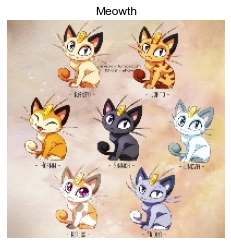

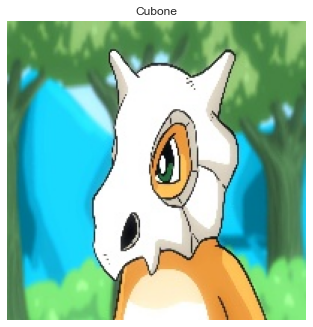

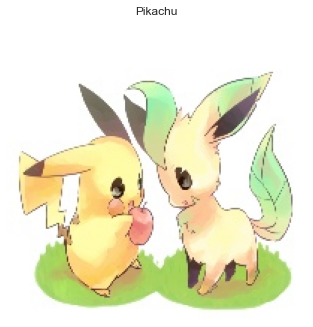

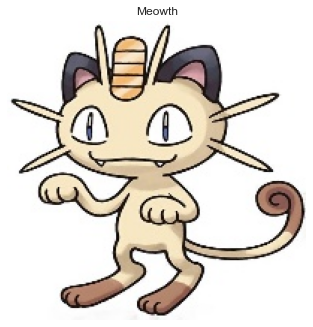

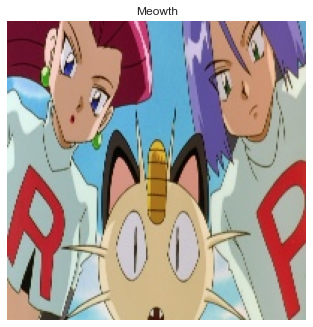

In [5]:
for i in range(0,5):
    drawImage(X[i], Y[i])

# Создаем два набора данных: для обучения и для тестирования

In [6]:
split_value = 0.8
split = int(X.shape[0] * split_value)

X_ = np.array(X)
Y_ = np.array(Y)

#Набор для обучения
X = X_[:split,:]
Y = Y_[:split]

#Набор для тестирования
XTest = X_[split:,:]
YTest = Y_[split:]

print(X.shape, Y.shape)
print(XTest.shape, YTest.shape)

(120, 200, 200, 3) (120,)
(30, 200, 200, 3) (30,)


# Строим нейронную сеть

In [10]:
def softmax(a):
    e_pa = np.exp(a)
    ans = e_pa/np.sum(e_pa, axis=1, keepdims=True)
    return ans

In [11]:
# Класс однослойной нейронной сети
class NeuralNetwork:
    
    def __init__(self, input_size, layers, output_size):
        np.random.seed(0)
        
        model = {}
        
        #Первый (входной) слой
        model['W1'] = np.random.randn(input_size, layers[0])
        model['b1'] = np.zeros((1, layers[0]))
        
        #Второй слой
        model['W2'] = np.random.randn(layers[0], layers[1])
        model['b2'] = np.zeros((1, layers[1]))
        
        #Третий (выходной слой)
        model['W3'] = np.random.randn(layers[1], output_size)
        model['b3'] = np.zeros((1, output_size))
        
        self.model = model
    
    def forward(self, x):
        
        W1,W2,W3 = self.model['W1'], self.model['W2'], self.model['W3']
        b1,b2,b3 = self.model['b1'], self.model['b2'], self.model['b3']
        
        z1 = np.dot(x, W1) + b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(a1, W2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2, W3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
        
    def backward(self, x, y, learning_rate=0.001):
        
        W1,W2,W3 = self.model['W1'], self.model['W2'], self.model['W3']
        b1,b2,b3 = self.model['b1'], self.model['b2'], self.model['b3']
        a1,a2,y_ = self.activation_outputs
        m = x.shape[0]
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3, W3.T)
        dw2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2, W2.T)
        dw1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0)
        
        #Обновляем параметры модели используя градиентный спуск
        self.model['W1'] -= learning_rate*dw1
        self.model['b1'] -= learning_rate*db1
        
        self.model['W2'] -= learning_rate*dw2
        self.model['b2'] -= learning_rate*db2
        
        self.model['W3'] -= learning_rate*dw3
        self.model['b3'] -= learning_rate*db3
        
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out, axis=1)
    
    def summary(self):
        
        W1,W2,W3 = self.model['W1'], self.model['W2'], self.model['W3']
        a1,a2,y_ = self.activation_outputs
        
        print('W1', W1.shape)
        print('A1', a1.shape)
        
        print('W2', W2.shape)
        print('A2', a2.shape)
        
        print('W3', W3.shape)
        print('Y_', y_.shape)

In [12]:
def loss(y_oht, p):
    
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y, depth):
    
    m = y.shape[0]
    y_oht = np.zeros((m, depth))
    y_oht[np.arange(m), y] = 1
    return y_oht

In [13]:
def train(X, Y, model, epochs, learning_rate, logs=True):
    
    training_loss = []
    
    classes = 3
    Y_OHT = one_hot(Y, classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT, Y_)
        training_loss.append(l)
        model.backward(X, Y_OHT, learning_rate)
        
        if(logs):
            print('Epoch %d Loss %.4f' %(ix,l))
    
    return training_loss

In [14]:
X = X.reshape(X.shape[0],-1)
print(X.shape)

XTest = XTest.reshape(XTest.shape[0], -1)
print(XTest.shape)

(120, 120000)
(30, 120000)


In [15]:
model_input_size = X.shape[-1]
print(model_input_size)
my_model = NeuralNetwork(input_size=model_input_size, layers=[100, 50], output_size=number_of_pokemons)

120000


In [28]:
import time
start_time = time.time()
l = train(X=X, Y=Y, model=my_model, epochs=400, learning_rate=0.0002)
print("--- {} seconds ---".format(time.time() - start_time))

Epoch 0 Loss 1.7519
Epoch 1 Loss 1.3850
Epoch 2 Loss 1.4150
Epoch 3 Loss 1.4711
Epoch 4 Loss 1.3819
Epoch 5 Loss 1.4154
Epoch 6 Loss 1.4014
Epoch 7 Loss 1.3402
Epoch 8 Loss 1.2906
Epoch 9 Loss 1.2445
Epoch 10 Loss 1.2138
Epoch 11 Loss 1.2324
Epoch 12 Loss 1.3558
Epoch 13 Loss 1.3269
Epoch 14 Loss 1.3209
Epoch 15 Loss 1.2057
Epoch 16 Loss 1.1856
Epoch 17 Loss 1.1145
Epoch 18 Loss 1.1565
Epoch 19 Loss 1.1036
Epoch 20 Loss 1.1075
Epoch 21 Loss 1.0285
Epoch 22 Loss 1.0111
Epoch 23 Loss 1.0388
Epoch 24 Loss 1.0427
Epoch 25 Loss 0.9738
Epoch 26 Loss 1.0033
Epoch 27 Loss 1.0368
Epoch 28 Loss 1.0101
Epoch 29 Loss 0.9497
Epoch 30 Loss 0.9623
Epoch 31 Loss 0.9427
Epoch 32 Loss 0.9113
Epoch 33 Loss 1.0012
Epoch 34 Loss 0.9782
Epoch 35 Loss 0.9392
Epoch 36 Loss 0.9472
Epoch 37 Loss 0.9271
Epoch 38 Loss 0.9115
Epoch 39 Loss 0.8973
Epoch 40 Loss 0.8936
Epoch 41 Loss 0.8706
Epoch 42 Loss 0.8613
Epoch 43 Loss 0.8840
Epoch 44 Loss 0.8699
Epoch 45 Loss 0.8625
Epoch 46 Loss 0.8436
Epoch 47 Loss 0.8682
Ep

Epoch 378 Loss 0.1107
Epoch 379 Loss 0.1104
Epoch 380 Loss 0.1100
Epoch 381 Loss 0.1098
Epoch 382 Loss 0.1095
Epoch 383 Loss 0.1093
Epoch 384 Loss 0.1092
Epoch 385 Loss 0.1089
Epoch 386 Loss 0.1085
Epoch 387 Loss 0.1082
Epoch 388 Loss 0.1080
Epoch 389 Loss 0.1077
Epoch 390 Loss 0.1076
Epoch 391 Loss 0.1072
Epoch 392 Loss 0.1070
Epoch 393 Loss 0.1068
Epoch 394 Loss 0.1064
Epoch 395 Loss 0.1062
Epoch 396 Loss 0.1059
Epoch 397 Loss 0.1058
Epoch 398 Loss 0.1055
Epoch 399 Loss 0.1054
--- 125.44375324249268 seconds ---


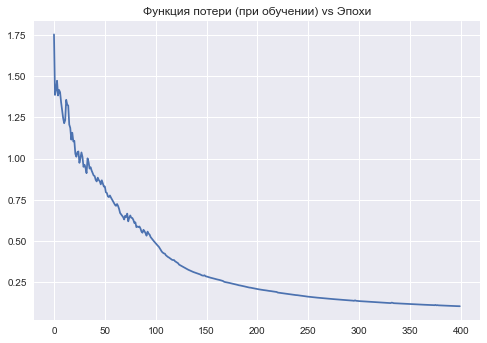

In [29]:
plt.title('Функция потери (при обучении) vs Эпохи')
plt.plot(l)
plt.show()

In [30]:
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc

print('Train Accuracy %.4f' %getAccuracy(X,Y,my_model))
print('Testing Accuracy %.4f' %getAccuracy(XTest,YTest,my_model))

Train Accuracy 0.9000
Testing Accuracy 0.2667


In [31]:
from sklearn.metrics import classification_report

In [32]:
outputs = my_model.predict(X)
print("{:*^60}\n".format('Отчет по обучающей выборке'), classification_report(outputs,Y))

*****************Отчет по обучающей выборке*****************
               precision    recall  f1-score   support

           0       0.87      0.94      0.90        35
           1       0.93      0.91      0.92        44
           2       0.90      0.85      0.88        41

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



In [33]:
test_outputs = my_model.predict(XTest)
print("{:*^60}\n".format('Отчет по тестовой выборке'), classification_report(test_outputs,YTest))

*****************Отчет по тестовой выборке******************
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         8
           1       0.00      0.00      0.00         8
           2       0.36      0.29      0.32        14

    accuracy                           0.27        30
   macro avg       0.23      0.26      0.24        30
weighted avg       0.26      0.27      0.26        30



[[33  0  2]
 [ 2 40  2]
 [ 3  3 35]]
         Pikachu  Cubone  Meowth
Pikachu       33       0       2
Cubone         2      40       2
Meowth         3       3      35


<AxesSubplot:>

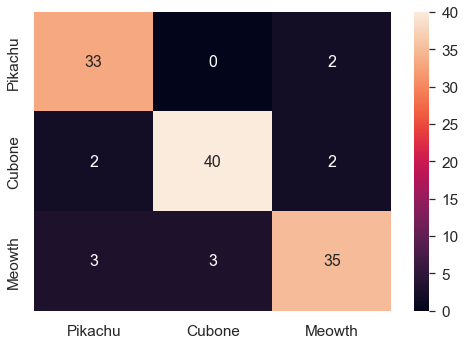

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cnf_matrix = confusion_matrix(outputs,Y)
print(cnf_matrix)

df_cm = pd.DataFrame(cnf_matrix, range(number_of_pokemons), range(number_of_pokemons))
df_cm.rename(columns=pokemon_label, index=pokemon_label, inplace=True)
print(df_cm)

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

[[4 2 2]
 [3 0 5]
 [5 5 4]]
         Pikachu  Cubone  Meowth
Pikachu        4       2       2
Cubone         3       0       5
Meowth         5       5       4


<AxesSubplot:>

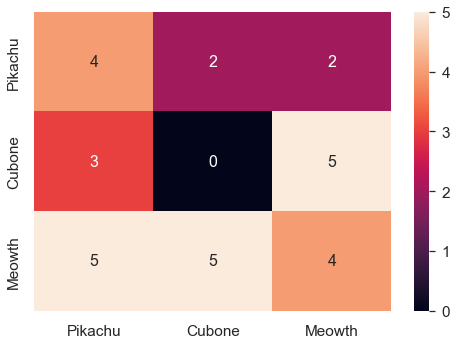

In [35]:
cnf_matrix_test = confusion_matrix(test_outputs,YTest)
print(cnf_matrix_test)

df_cm_test = pd.DataFrame(cnf_matrix_test, range(number_of_pokemons), range(number_of_pokemons))
df_cm_test.rename(columns=pokemon_label, index=pokemon_label, inplace=True)
print(df_cm_test)

sn.set(font_scale=1.4)
sn.heatmap(df_cm_test, annot=True, annot_kws={"size": 16})

# Визуализируйте ошибочные классификации

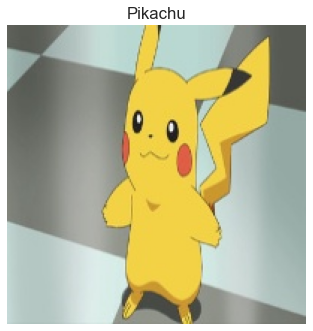

Prediction 7 Meowth


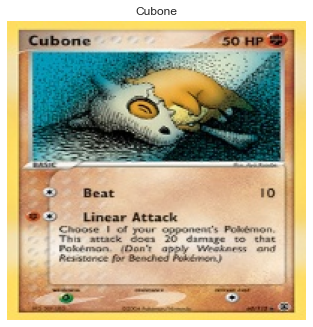

Prediction 22 Meowth


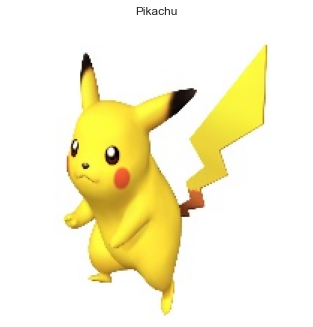

Prediction 26 Cubone


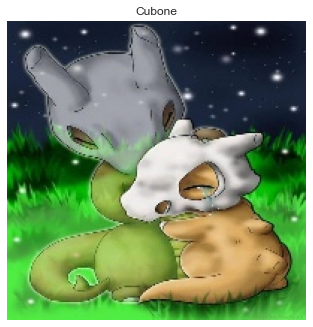

Prediction 53 Meowth


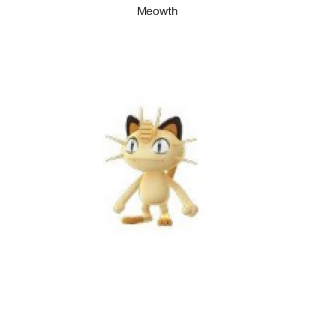

Prediction 55 Cubone


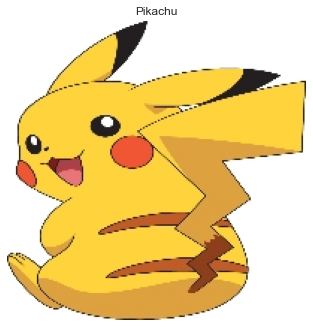

Prediction 60 Meowth


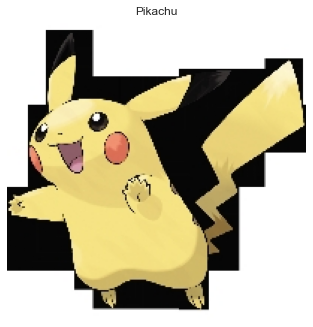

Prediction 73 Meowth


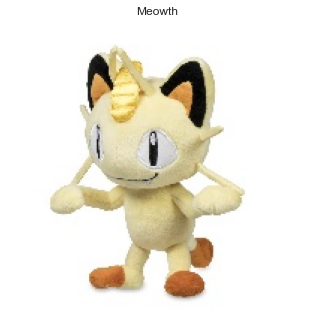

Prediction 74 Pikachu


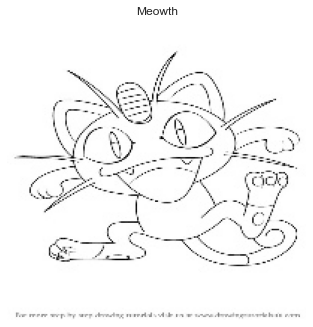

Prediction 79 Pikachu


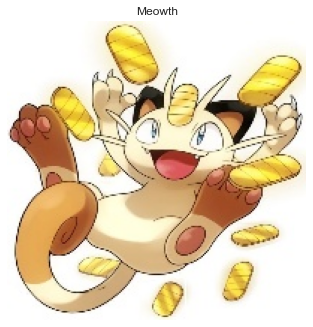

Prediction 84 Cubone


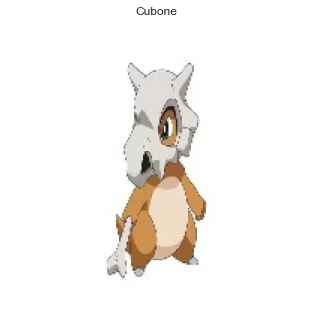

Prediction 108 Meowth


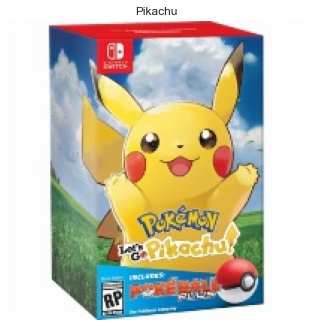

Prediction 117 Cubone


In [36]:
for i in range(Y.shape[0]):
    if Y[i] != outputs[i]:
        drawImage(X[i].reshape(200,200,3), Y[i])
        plt.show()
        print("Prediction %d %s" %(i, pokemon_label[outputs[i]]))

# Использование других моделей

In [37]:
def print_report(model, X, Y):
    """
    Функция для печати отчета по моделе:
    - Матрица ошибки
    - Текстовый отчет по основным метрикам
    ---------------------------------------
    > model - переменная модели из библиотеки sklearn
    > X - матрица признаков
    > Y - матрица правильных ответов
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sn
    
    y_pred = model.predict(X)
    matrix = confusion_matrix(y_pred, Y)

    df_matrix = pd.DataFrame(matrix, range(number_of_pokemons), range(number_of_pokemons))
    df_matrix.rename(columns=pokemon_label, index=pokemon_label, inplace=True)
    
    sn.set(font_scale=1.4)
    sn.heatmap(df_matrix, annot=True, annot_kws={"size": 16})
    print(classification_report(y_pred,Y))
    return y_pred

In [38]:
def print_learning_curve(model, x_train, y_train, train_sizes, model_label):
    """
    Функция для вывода прямой обучения learning_curve
    ---------------------------------------
    > model - переменная модели из библиотеки sklearn
    > x_train - матрица признаков
    > y_train - матрица правильных ответов
    > train_sizes - относительное или абсолютное количество обучающих примеров
    > model_label - тип модели (отрисовывается на графике)
    """
    from sklearn.model_selection import learning_curve
    _, train_scores, test_scores = learning_curve(model, x_train, y_train, train_sizes=train_sizes, cv=3)
    print(np.mean(test_scores,axis=1))
    
    plt.figure('Прямая обучения')
    plt.xlabel('train size')
    plt.ylabel('F1 score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label=model_label, color='green')
    plt.legend()
    plt.show()

In [39]:
def print_misidentifications(X, Y, y_pred):
    """
    Функция для вывода ошибочных классификаций
    ---------------------------------------
    > X - матрица признаков
    > Y - матрица правильных ответов
    > y_pred - матрица предсказаний
    """
    for i in range(Y.shape[0]):
        if Y[i] != y_pred[i]:
            drawImage(X[i].reshape(200,200,3), Y[i])
            plt.show()
            print("Prediction %d %s" %(i, pokemon_label[y_pred[i]]))

# Метод опорных векторов (линейное ядро)

In [40]:
%%time
from sklearn import svm

# Метод опорных векторов с линейным ядром 
clf_lin = svm.SVC(kernel='linear') 
clf_lin.fit(X, Y)

Wall time: 1.88 s


SVC(kernel='linear')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        39

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



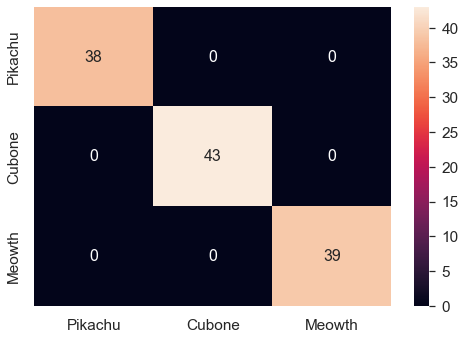

In [41]:
# Обучение
y_pred_vec_lin = print_report(clf_lin, X, Y) 

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.86      0.60      0.71        10
           2       0.82      0.90      0.86        10

    accuracy                           0.83        30
   macro avg       0.84      0.83      0.82        30
weighted avg       0.84      0.83      0.82        30



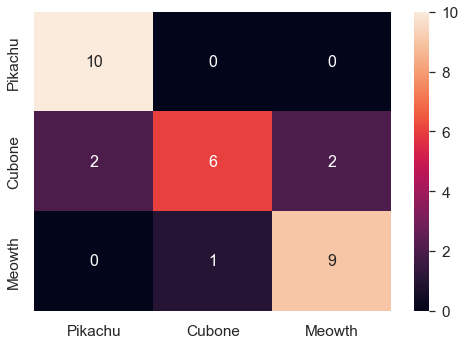

In [42]:
# Проверка на тестовой выборке
y_pred_vec_lin_test = print_report(clf_lin, XTest, YTest) 

[0.475      0.59166667 0.68333333 0.69166667 0.68333333 0.725
 0.68333333 0.66666667 0.725      0.725     ]


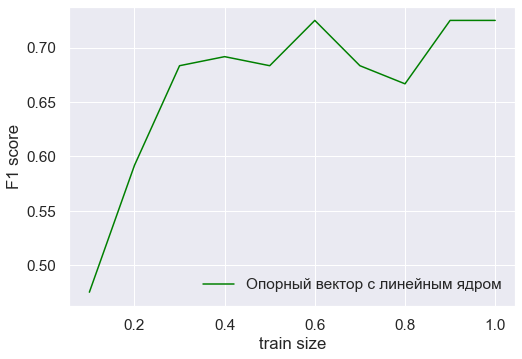

In [43]:
# Прямая обучения для опорных векторов с линейным ядром
print_learning_curve(clf_lin, X, Y, train_sizes=np.linspace(0.1, 1, 10), model_label="Опорный вектор с линейным ядром")

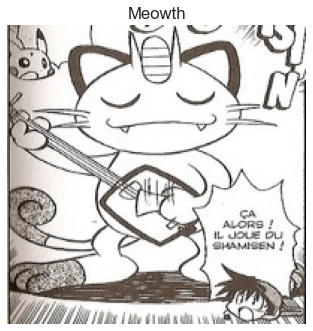

Prediction 5 Cubone


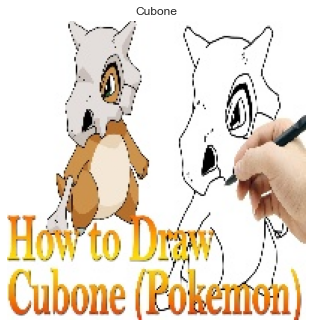

Prediction 8 Meowth


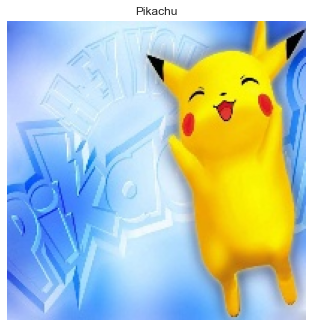

Prediction 11 Cubone


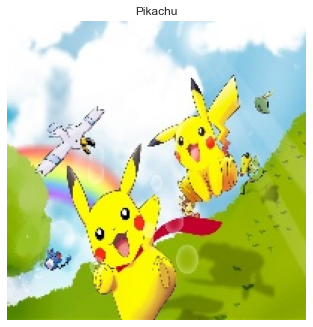

Prediction 17 Cubone


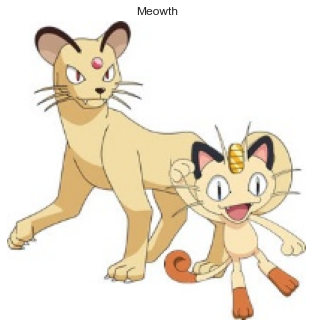

Prediction 25 Cubone


In [44]:
# Выводим все ошибочные предсказания (по тестовой выборке)
print_misidentifications(XTest, YTest, y_pred_vec_lin_test)

# Метод опорных векторов (ядро Радиальной Базовой Функции)

In [45]:
%%time
from sklearn import svm

# Метод опорных векторов с ядром РБФ
clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X, Y)

Wall time: 2 s


SVC()

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        37
           1       1.00      0.96      0.98        45
           2       0.97      1.00      0.99        38

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



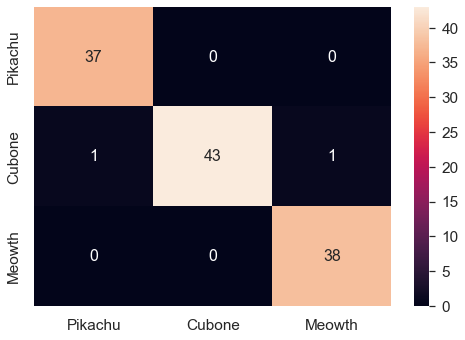

In [46]:
# Обучение
y_pred_vec_rbf = print_report(clf_rbf, X, Y) 

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.86      0.55      0.67        11
           2       0.64      0.78      0.70         9

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



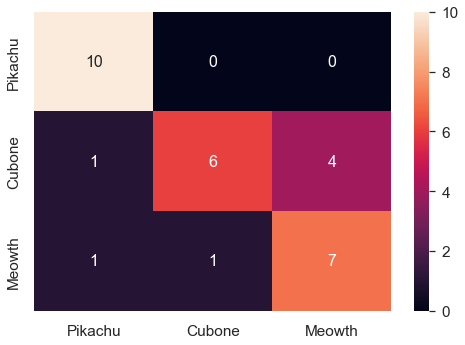

In [47]:
# Тестирование
y_pred_vec_rbf_test = print_report(clf_rbf, XTest, YTest) 

[0.35       0.31666667 0.36666667 0.45833333 0.49166667 0.5
 0.55833333 0.55       0.65       0.65833333]


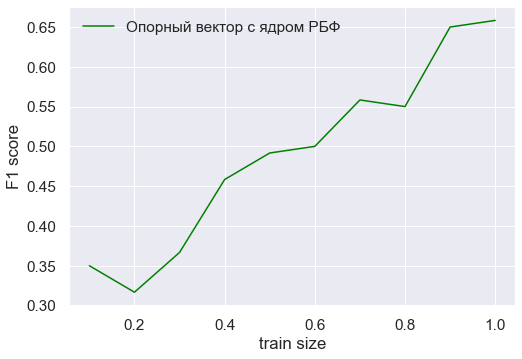

In [48]:
print_learning_curve(clf_rbf, X, Y, train_sizes=np.linspace(0.1, 1, 10), model_label="Опорный вектор с ядром РБФ")

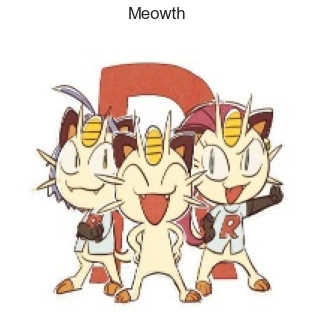

Prediction 3 Cubone


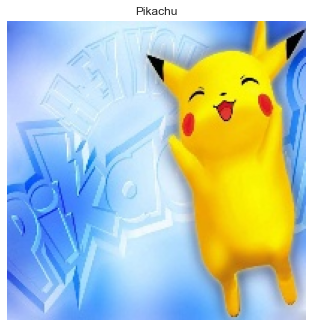

Prediction 11 Meowth


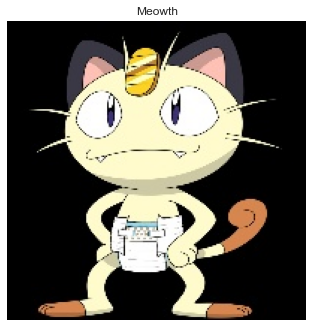

Prediction 15 Cubone


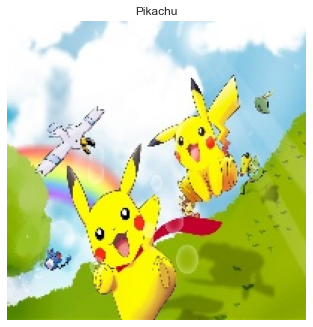

Prediction 17 Cubone


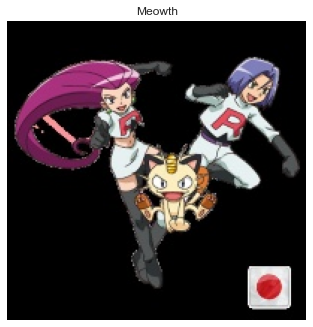

Prediction 20 Cubone


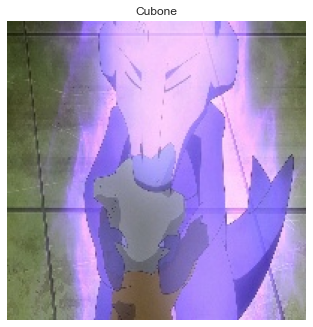

Prediction 24 Meowth


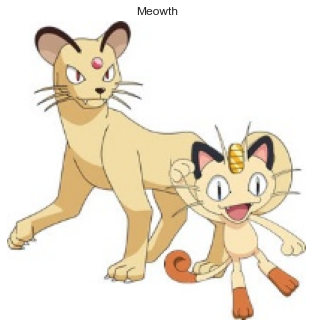

Prediction 25 Cubone


In [49]:
print_misidentifications(XTest, YTest, y_pred_vec_rbf_test)

# Метод k ближайших соседей

In [50]:
%%time
from sklearn.neighbors import KNeighborsClassifier
import math

neighbors_val = 5 #int(math.sqrt(X.shape[0]))

neigh = KNeighborsClassifier(n_neighbors=neighbors_val)
neigh.fit(X, Y)

Wall time: 53.8 ms


KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.58      0.96      0.72        23
           1       0.84      0.58      0.69        62
           2       0.72      0.80      0.76        35

    accuracy                           0.72       120
   macro avg       0.71      0.78      0.72       120
weighted avg       0.75      0.72      0.71       120



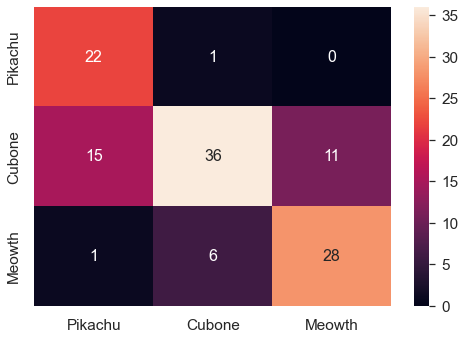

In [51]:
# Обучение
y_pred_neigh = print_report(neigh, X, Y) 

              precision    recall  f1-score   support

           0       0.58      0.78      0.67         9
           1       0.86      0.46      0.60        13
           2       0.73      1.00      0.84         8

    accuracy                           0.70        30
   macro avg       0.72      0.75      0.70        30
weighted avg       0.74      0.70      0.68        30



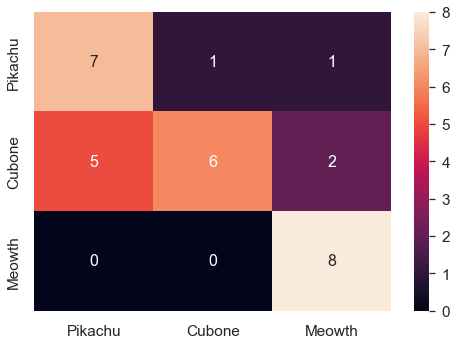

In [52]:
# Тестирование
y_pred_neigh_test = print_report(neigh, XTest, YTest) 

[0.33333333 0.35       0.44166667 0.46666667 0.44166667 0.41666667
 0.45       0.475      0.46666667 0.49166667 0.49166667 0.50833333
 0.5        0.53333333 0.55       0.50833333 0.5        0.53333333
 0.55       0.525     ]


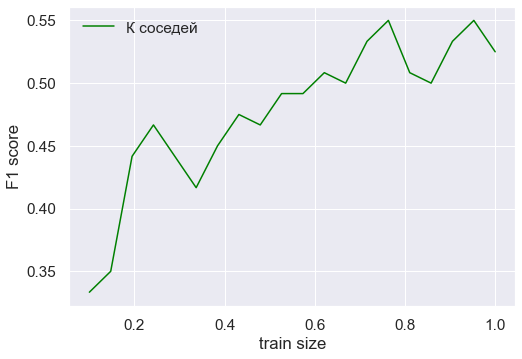

In [53]:
print_learning_curve(neigh, X, Y, train_sizes=np.linspace(0.1, 1, 20), model_label="К соседей")

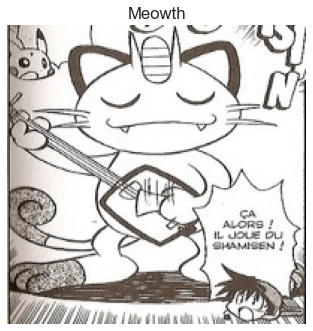

Prediction 5 Pikachu


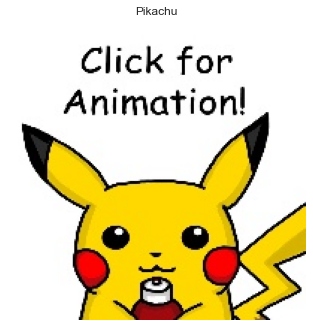

Prediction 7 Cubone


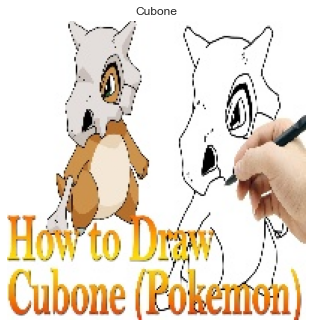

Prediction 8 Pikachu


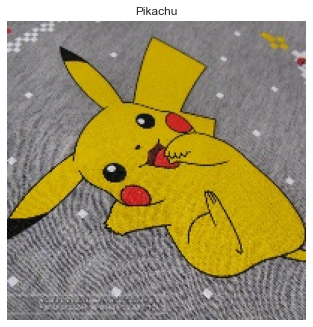

Prediction 10 Cubone


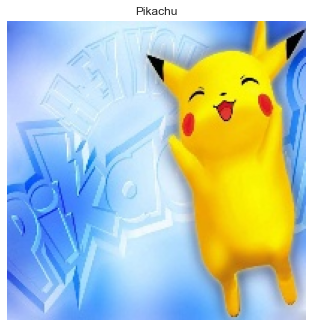

Prediction 11 Cubone


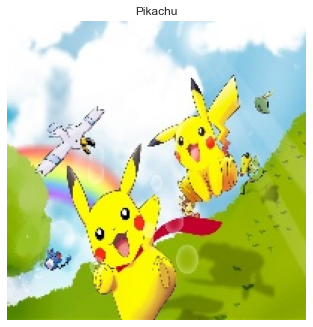

Prediction 17 Cubone


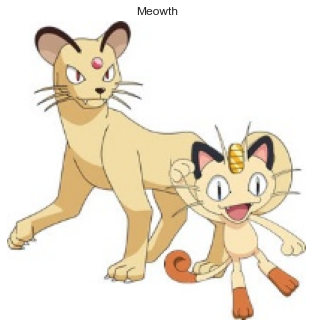

Prediction 25 Cubone


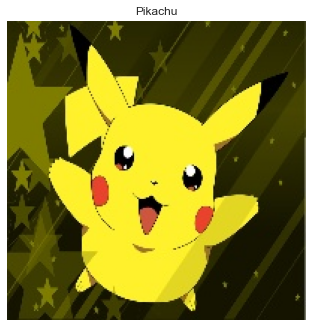

Prediction 26 Cubone


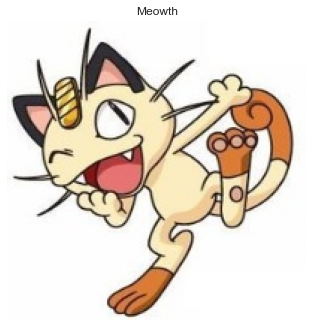

Prediction 28 Cubone


In [54]:
print_misidentifications(XTest, YTest, y_pred_neigh_test)

# Нейронная сеть

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [17]:
# Создаем новые переменные с правильными ответами 
# метод to_categorical преобразует вектор класса в бинарную матрицу класса
Y_cat = to_categorical(Y, number_of_pokemons)
YTest_cat = to_categorical(YTest, number_of_pokemons)

In [18]:
print("Исходный размер", model_input_size)

Исходный размер 120000


### Первая модель

In [19]:
mlp_1 = Sequential()

mlp_1.add(Dense(512, activation='relu', input_shape=(model_input_size,)))
mlp_1.add(Dense(number_of_pokemons, activation='softmax'))

mlp_1.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

In [20]:
%%time
history_mlp_1 = mlp_1.fit(X, Y_cat, batch_size=256, epochs=200, verbose=1,
                    validation_data=(XTest, YTest_cat))

Epoch 1/200
1/1 [==============================] - 1s 657ms/step - loss: 0.2718 - accuracy: 0.3750 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 2/200
1/1 [==============================] - 0s 291ms/step - loss: 0.4492 - accuracy: 0.3250 - val_loss: 0.4221 - val_accuracy: 0.3667
Epoch 3/200
1/1 [==============================] - 0s 305ms/step - loss: 0.4491 - accuracy: 0.3250 - val_loss: 0.4221 - val_accuracy: 0.3667
Epoch 4/200
1/1 [==============================] - 0s 291ms/step - loss: 0.4489 - accuracy: 0.3250 - val_loss: 0.4221 - val_accuracy: 0.3667
Epoch 5/200
1/1 [==============================] - 0s 312ms/step - loss: 0.4487 - accuracy: 0.3250 - val_loss: 0.4221 - val_accuracy: 0.3667
Epoch 6/200
1/1 [==============================] - 0s 352ms/step - loss: 0.4483 - accuracy: 0.3250 - val_loss: 0.4220 - val_accuracy: 0.3667
Epoch 7/200
1/1 [==============================] - 0s 295ms/step - loss: 0.4478 - accuracy: 0.3250 - val_loss: 0.4219 - val_accuracy: 0.3667
Epoch 8/200
1

Epoch 59/200
1/1 [==============================] - 0s 280ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 60/200
1/1 [==============================] - 0s 283ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 61/200
1/1 [==============================] - 0s 284ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 62/200
1/1 [==============================] - 0s 281ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 63/200
1/1 [==============================] - 0s 289ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 64/200
1/1 [==============================] - 0s 284ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 65/200
1/1 [==============================] - 0s 286ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 

1/1 [==============================] - 0s 290ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 117/200
1/1 [==============================] - 0s 286ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 118/200
1/1 [==============================] - 0s 311ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 119/200
1/1 [==============================] - 0s 298ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 120/200
1/1 [==============================] - 0s 306ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 121/200
1/1 [==============================] - 0s 308ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 122/200
1/1 [==============================] - 0s 289ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 123/200

1/1 [==============================] - 0s 283ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 174/200
1/1 [==============================] - 0s 281ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 175/200
1/1 [==============================] - 0s 308ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 176/200
1/1 [==============================] - 0s 296ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 177/200
1/1 [==============================] - 0s 278ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 178/200
1/1 [==============================] - 0s 269ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 179/200
1/1 [==============================] - 0s 298ms/step - loss: 0.4500 - accuracy: 0.3250 - val_loss: 0.4222 - val_accuracy: 0.3667
Epoch 180/200

In [21]:
result_1 = mlp_1.evaluate(XTest, YTest_cat, batch_size=256)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(result_1[0], result_1[1]))

1/1 [==============================] - 0s 69ms/step - loss: 0.4222 - accuracy: 0.3667
Evaluation result on Test Data : Loss = 0.42222222685813904, accuracy = 0.36666667461395264


### Вторая модель

In [22]:
mlp_2 = Sequential()

mlp_2.add(Dense(512, activation='relu', input_shape=(model_input_size,)))
mlp_2.add(Dense(256, activation='relu'))
mlp_2.add(Dense(number_of_pokemons, activation='softmax'))

mlp_2.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

In [23]:
%%time
history_mlp_2 = mlp_2.fit(X, Y_cat, batch_size=256, epochs=200, verbose=1,
                    validation_data=(XTest, YTest_cat))

Epoch 1/200
1/1 [==============================] - 1s 616ms/step - loss: 0.3269 - accuracy: 0.3250 - val_loss: 0.3320 - val_accuracy: 0.2333
Epoch 2/200
1/1 [==============================] - 0s 294ms/step - loss: 0.2939 - accuracy: 0.3500 - val_loss: 0.3960 - val_accuracy: 0.4000
Epoch 3/200
1/1 [==============================] - 0s 302ms/step - loss: 0.4539 - accuracy: 0.3167 - val_loss: 0.3959 - val_accuracy: 0.4000
Epoch 4/200
1/1 [==============================] - 0s 296ms/step - loss: 0.4538 - accuracy: 0.3167 - val_loss: 0.3957 - val_accuracy: 0.4000
Epoch 5/200
1/1 [==============================] - 0s 311ms/step - loss: 0.4536 - accuracy: 0.3167 - val_loss: 0.3956 - val_accuracy: 0.4000
Epoch 6/200
1/1 [==============================] - 0s 322ms/step - loss: 0.4533 - accuracy: 0.3167 - val_loss: 0.3954 - val_accuracy: 0.4000
Epoch 7/200
1/1 [==============================] - 0s 321ms/step - loss: 0.4530 - accuracy: 0.3167 - val_loss: 0.3951 - val_accuracy: 0.4000
Epoch 8/200
1

Epoch 59/200
1/1 [==============================] - 0s 289ms/step - loss: 0.2537 - accuracy: 0.4083 - val_loss: 0.2259 - val_accuracy: 0.4000
Epoch 60/200
1/1 [==============================] - 0s 289ms/step - loss: 0.2094 - accuracy: 0.4333 - val_loss: 0.2546 - val_accuracy: 0.4333
Epoch 61/200
1/1 [==============================] - 0s 299ms/step - loss: 0.2595 - accuracy: 0.4250 - val_loss: 0.3340 - val_accuracy: 0.2667
Epoch 62/200
1/1 [==============================] - 0s 298ms/step - loss: 0.2709 - accuracy: 0.4250 - val_loss: 0.2040 - val_accuracy: 0.4333
Epoch 63/200
1/1 [==============================] - 0s 300ms/step - loss: 0.1919 - accuracy: 0.4667 - val_loss: 0.2208 - val_accuracy: 0.4667
Epoch 64/200
1/1 [==============================] - 0s 300ms/step - loss: 0.1949 - accuracy: 0.5250 - val_loss: 0.2040 - val_accuracy: 0.5000
Epoch 65/200
1/1 [==============================] - 0s 289ms/step - loss: 0.1690 - accuracy: 0.5917 - val_loss: 0.1745 - val_accuracy: 0.6667
Epoch 

1/1 [==============================] - 0s 307ms/step - loss: 0.1421 - accuracy: 0.6833 - val_loss: 0.1300 - val_accuracy: 0.6333
Epoch 117/200
1/1 [==============================] - 0s 362ms/step - loss: 0.1183 - accuracy: 0.7333 - val_loss: 0.1697 - val_accuracy: 0.6667
Epoch 118/200
1/1 [==============================] - 0s 287ms/step - loss: 0.1267 - accuracy: 0.7750 - val_loss: 0.1238 - val_accuracy: 0.7000
Epoch 119/200
1/1 [==============================] - 0s 290ms/step - loss: 0.1017 - accuracy: 0.7583 - val_loss: 0.1592 - val_accuracy: 0.6667
Epoch 120/200
1/1 [==============================] - 0s 291ms/step - loss: 0.1142 - accuracy: 0.7000 - val_loss: 0.1565 - val_accuracy: 0.7000
Epoch 121/200
1/1 [==============================] - 0s 341ms/step - loss: 0.1526 - accuracy: 0.6583 - val_loss: 0.2091 - val_accuracy: 0.4333
Epoch 122/200
1/1 [==============================] - 0s 290ms/step - loss: 0.2081 - accuracy: 0.5417 - val_loss: 0.2381 - val_accuracy: 0.4000
Epoch 123/200

1/1 [==============================] - 0s 288ms/step - loss: 0.1244 - accuracy: 0.6917 - val_loss: 0.1250 - val_accuracy: 0.7667
Epoch 174/200
1/1 [==============================] - 0s 288ms/step - loss: 0.0734 - accuracy: 0.8833 - val_loss: 0.1279 - val_accuracy: 0.7000
Epoch 175/200
1/1 [==============================] - 0s 285ms/step - loss: 0.0949 - accuracy: 0.7667 - val_loss: 0.1375 - val_accuracy: 0.7667
Epoch 176/200
1/1 [==============================] - 0s 286ms/step - loss: 0.0829 - accuracy: 0.8167 - val_loss: 0.1333 - val_accuracy: 0.7333
Epoch 177/200
1/1 [==============================] - 0s 285ms/step - loss: 0.1038 - accuracy: 0.7500 - val_loss: 0.1258 - val_accuracy: 0.7000
Epoch 178/200
1/1 [==============================] - 0s 283ms/step - loss: 0.0781 - accuracy: 0.8583 - val_loss: 0.1421 - val_accuracy: 0.7000
Epoch 179/200
1/1 [==============================] - 0s 286ms/step - loss: 0.0957 - accuracy: 0.8000 - val_loss: 0.1627 - val_accuracy: 0.6000
Epoch 180/200

In [24]:
result_2 = mlp_2.evaluate(XTest, YTest_cat, batch_size=256)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(result_2[0], result_2[1]))

1/1 [==============================] - 0s 69ms/step - loss: 0.1574 - accuracy: 0.6667
Evaluation result on Test Data : Loss = 0.15736518800258636, accuracy = 0.6666666865348816


### Третья модель

In [25]:
mlp_3 = Sequential()

mlp_3.add(Dense(512, activation='relu', input_shape=(model_input_size,)))
mlp_3.add(Dense(256, activation='relu'))
mlp_3.add(Dense(128, activation='relu'))
mlp_3.add(Dense(number_of_pokemons, activation='softmax'))

mlp_3.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

In [26]:
%%time
history_mlp_3 = mlp_3.fit(X, Y_cat, batch_size=256, epochs=200, verbose=1,
                    validation_data=(XTest, YTest_cat))

Epoch 1/200
1/1 [==============================] - 1s 638ms/step - loss: 0.3154 - accuracy: 0.3167 - val_loss: 0.3520 - val_accuracy: 0.3667
Epoch 2/200
1/1 [==============================] - 0s 297ms/step - loss: 0.3570 - accuracy: 0.3250 - val_loss: 0.4809 - val_accuracy: 0.2333
Epoch 3/200
1/1 [==============================] - 0s 303ms/step - loss: 0.4039 - accuracy: 0.3583 - val_loss: 0.4582 - val_accuracy: 0.2333
Epoch 4/200
1/1 [==============================] - 0s 308ms/step - loss: 0.3837 - accuracy: 0.3583 - val_loss: 0.3103 - val_accuracy: 0.2333
Epoch 5/200
1/1 [==============================] - 0s 306ms/step - loss: 0.2700 - accuracy: 0.3667 - val_loss: 0.2674 - val_accuracy: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 354ms/step - loss: 0.2920 - accuracy: 0.3250 - val_loss: 0.3362 - val_accuracy: 0.4000
Epoch 7/200
1/1 [==============================] - 0s 305ms/step - loss: 0.3843 - accuracy: 0.3167 - val_loss: 0.2179 - val_accuracy: 0.4333
Epoch 8/200
1

Epoch 59/200
1/1 [==============================] - 0s 343ms/step - loss: 0.1799 - accuracy: 0.5417 - val_loss: 0.2613 - val_accuracy: 0.4000
Epoch 60/200
1/1 [==============================] - 0s 328ms/step - loss: 0.2147 - accuracy: 0.6000 - val_loss: 0.3289 - val_accuracy: 0.2333
Epoch 61/200
1/1 [==============================] - 0s 307ms/step - loss: 0.2617 - accuracy: 0.4333 - val_loss: 0.3371 - val_accuracy: 0.3667
Epoch 62/200
1/1 [==============================] - 0s 298ms/step - loss: 0.3513 - accuracy: 0.3750 - val_loss: 0.1741 - val_accuracy: 0.6333
Epoch 63/200
1/1 [==============================] - 0s 329ms/step - loss: 0.1935 - accuracy: 0.6167 - val_loss: 0.2083 - val_accuracy: 0.5000
Epoch 64/200
1/1 [==============================] - 0s 339ms/step - loss: 0.2155 - accuracy: 0.5000 - val_loss: 0.2515 - val_accuracy: 0.4333
Epoch 65/200
1/1 [==============================] - 0s 282ms/step - loss: 0.2671 - accuracy: 0.4083 - val_loss: 0.2538 - val_accuracy: 0.2333
Epoch 

1/1 [==============================] - 0s 293ms/step - loss: 0.1220 - accuracy: 0.8083 - val_loss: 0.1166 - val_accuracy: 0.7333
Epoch 117/200
1/1 [==============================] - 0s 369ms/step - loss: 0.0874 - accuracy: 0.9000 - val_loss: 0.1257 - val_accuracy: 0.7333
Epoch 118/200
1/1 [==============================] - 0s 294ms/step - loss: 0.0885 - accuracy: 0.8667 - val_loss: 0.1300 - val_accuracy: 0.7000
Epoch 119/200
1/1 [==============================] - 0s 288ms/step - loss: 0.1020 - accuracy: 0.7667 - val_loss: 0.1621 - val_accuracy: 0.6333
Epoch 120/200
1/1 [==============================] - 0s 288ms/step - loss: 0.1375 - accuracy: 0.6417 - val_loss: 0.2360 - val_accuracy: 0.5000
Epoch 121/200
1/1 [==============================] - 0s 287ms/step - loss: 0.1880 - accuracy: 0.6583 - val_loss: 0.2373 - val_accuracy: 0.4333
Epoch 122/200
1/1 [==============================] - 0s 312ms/step - loss: 0.2373 - accuracy: 0.4667 - val_loss: 0.2737 - val_accuracy: 0.3333
Epoch 123/200

1/1 [==============================] - 0s 291ms/step - loss: 0.0896 - accuracy: 0.7833 - val_loss: 0.1425 - val_accuracy: 0.6667
Epoch 174/200
1/1 [==============================] - 0s 288ms/step - loss: 0.0906 - accuracy: 0.8083 - val_loss: 0.1128 - val_accuracy: 0.7333
Epoch 175/200
1/1 [==============================] - 0s 290ms/step - loss: 0.0707 - accuracy: 0.8750 - val_loss: 0.1291 - val_accuracy: 0.7000
Epoch 176/200
1/1 [==============================] - 0s 298ms/step - loss: 0.0782 - accuracy: 0.8250 - val_loss: 0.1124 - val_accuracy: 0.7333
Epoch 177/200
1/1 [==============================] - 0s 316ms/step - loss: 0.0718 - accuracy: 0.8333 - val_loss: 0.1368 - val_accuracy: 0.6333
Epoch 178/200
1/1 [==============================] - 0s 289ms/step - loss: 0.0787 - accuracy: 0.8167 - val_loss: 0.1298 - val_accuracy: 0.7000
Epoch 179/200
1/1 [==============================] - 0s 298ms/step - loss: 0.1022 - accuracy: 0.7583 - val_loss: 0.1189 - val_accuracy: 0.7000
Epoch 180/200

In [27]:
result_3 = mlp_3.evaluate(XTest, YTest_cat, batch_size=256)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(result_3[0], result_3[1]))

1/1 [==============================] - 0s 76ms/step - loss: 0.1308 - accuracy: 0.7333
Evaluation result on Test Data : Loss = 0.13077396154403687, accuracy = 0.7333333492279053
